<a href="https://colab.research.google.com/github/emigu777/IANNwTF20/blob/main/Homework5/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Homework 5 

 ### 2 . CIFAR10 - Classification 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Feature structure: 
id: Text(dtype=object)
image: Image(shape=(32,32,3), dtype=uint8)
label: ClassLabel(dtype=int64, num_classes=10)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np


In [ ]:
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info = True)
#print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete7AI6SX/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete7AI6SX/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
def prepare_cifar10_data(cifar, batchsize = 32):
  '''
  This function prepares the dataset for usage in a learning model

  Args:
  cifar --- The cifar-10 dataset 
  batchsize --- The batch size (default:32)

  Returns:
  cifar --- The processed dataset

  '''
  #convert data from uint8 to float32 
  cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  cifar = cifar.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory
  cifar = cifar.cache()
  #shuffle, batch, prefetch
  cifar = cifar.shuffle(1000)
  cifar = cifar.batch(batchsize)
  cifar= cifar.prefetch(tf.data.AUTOTUNE)
  #return preprocessed dataset
  return cifar


train_dataset = train_ds.apply(prepare_cifar10_data)
test_dataset = test_ds.apply(prepare_cifar10_data)

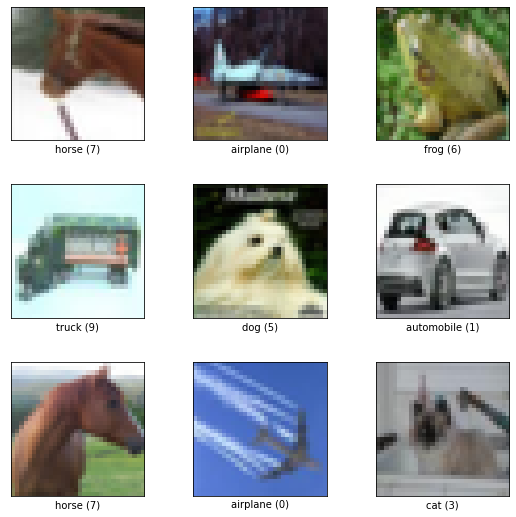

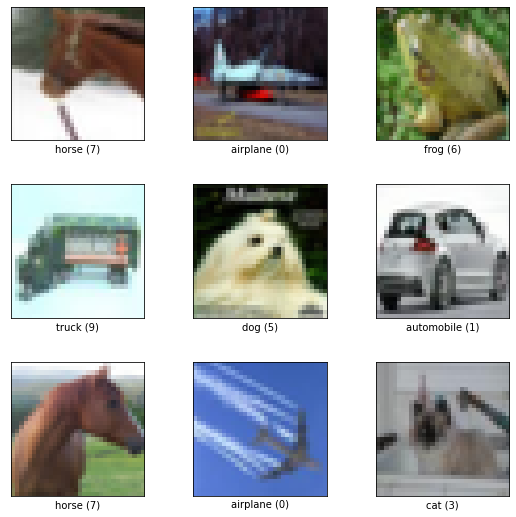

In [ ]:
tfds.visualization.show_examples(test_ds, ds_info)

## Creating the Model

In [ ]:
class ConvModel(tf.keras.Model):
    def __init__(self, layers_list, optimizer):
        super().__init__()

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = optimizer

        #instantiating layers through given list with layer objects
        self.con_layers = layers_list
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

        #metric objects to keep track of loss and accuracy
        self.metrics_list = [tf.keras.metrics.Mean(name="loss"), tf.keras.metrics.CategoricalAccuracy(name="accuracy")]

    @tf.function
    def call(self, input):
        '''
        Propagates input through network

        Args:
        input --- the network's input

        Returns:
        out --- the network's output
        '''
        out = self.con_layers[0](input)
        for layer in self.con_layers[1:]:
            out = layer(out)
        out = self.out(out)
        return out 

    #metrics property 
    @property
    def metrics(self):
        # returns a list with all metrics in the model
        return self.metrics_list


    def reset_metrics(self):
        # reset all metrics objects
        for metric in self.metrics:
            metric.reset_states()


    @tf.function
    def train_step(self, input):
        '''
        Updates the trainable variables according to the calculated gradients 

        Args:
        input --- the input on which the training step is executed

        Returns:
        A dictionary of loss and accuracy metrices 
        '''
        img, target = input
        
        with tf.GradientTape() as tape:
            #create networks prediction
            output = self(img, training=True)
            loss = self.loss_function(target, output)
        #calculating gradients    
        gradients = tape.gradient(loss, self.trainable_variables)
        
        #applying gradients and updating model
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(target, output)

        
        # return a dictionary with metric names as keys and metric results as values
        return [m.result() for m in self.metrics]

    @tf.function
    def test_step(self, data):
        ''' 
        Tests how model performs on data it wasn't trained on 

        Args:
        data --- test data

        Returns:
        A dictionary of loss and accuracy metrices 
        '''
        img, target = data 

        #predict output and calculate loss
        output = self(img, training=True)
        loss = self.loss_function(target, output)

        # update the state of the metrics according to loss
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(target, output)

        return [m.result() for m in self.metrics]






        


## Training the network

In [ ]:
def training_loop(model, train_data, test_data, epochs):
    ''' 
    The training loop of our model

    Args:
    model --- the model object 
    epochs --- number of training steps
    '''

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    #test metrics before training 
    for data in test_data:
        test_loss, test_accuracy = model.test_step(data)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    model.reset_metrics()

    for epoch in range(epochs):

        #print accuracy every epoch
        print(f'Epoch {str(epoch)}: Accuracy {test_accuracies[-1]}')

        #train the network
        for data in train_data:
                train_loss, train_accuracy = model.train_step(data)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.reset_metrics()

        # test the network
        for data in test_dataset:
                test_loss, test_accuracy = model.test_step(data)
        test_losses.append(test_loss.numpy())
        test_accuracies.append(test_accuracy.numpy())

        model.reset_metrics()

    return train_losses, train_accuracies, test_losses, test_accuracies



In [ ]:
#training for 15 epochs
epochs = 15

#same layer config as in lecture 
layers_list = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'), 
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.GlobalAvgPool2D()]

#using Adam optimizer
optimizer = tf.keras.optimizers.Adam()

#instantiate model
cnnmodel = ConvModel(layers_list, optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = training_loop(cnnmodel, train_dataset, test_dataset, epochs)





Epoch 0: Accuracy 0.09960000216960907
Epoch 1: Accuracy 0.4799000024795532
Epoch 2: Accuracy 0.5429999828338623
Epoch 3: Accuracy 0.5698999762535095
Epoch 4: Accuracy 0.599399983882904
Epoch 5: Accuracy 0.6015999913215637
Epoch 6: Accuracy 0.6486999988555908
Epoch 7: Accuracy 0.6658999919891357
Epoch 8: Accuracy 0.6919999718666077
Epoch 9: Accuracy 0.6851999759674072
Epoch 10: Accuracy 0.6991000175476074
Epoch 11: Accuracy 0.7055000066757202
Epoch 12: Accuracy 0.7128999829292297
Epoch 13: Accuracy 0.6614999771118164
Epoch 14: Accuracy 0.7250999808311462


The first configuration had an accuracy score of about 73% after 15 epochs.

## Visualization

In [ ]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    ''' 
    Visualizes training progress by showing losses and accuracies after every epoch

    Args:
    train_losses --- loss during training 
    train_accuracies -- accuracy during training 
    test_losses --- loss during testing 
    test_accuracies --- accuracy during testing 
    '''

    fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)
    axes[0].plot(train_losses, color = "pink", label = "Training")
    axes[0].plot(test_losses, color = "lightblue", label = "Testing")
    axes[1].plot(train_accuracies, color = "pink")
    axes[1].plot(test_accuracies, color = "lightblue")

    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0,1)
    axes[1].set_xlabel("Training steps")


    plt.show()





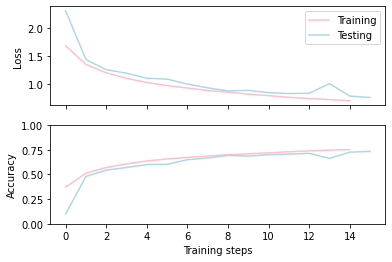

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## Experimenting with Hyperparameters and Architecture

In [ ]:
#taking only a subset of data to speed up process
small_train_ds = train_ds.take(30000)
small_test_ds = test_ds.take(5000)

small_train_dataset = small_train_ds.apply(prepare_cifar10_data)
small_test_dataset = small_test_ds.apply(prepare_cifar10_data)


In [ ]:
layers_list = [tf.keras.layers.Conv2D(filters= 20, kernel_size=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=20, kernel_size=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=20, kernel_size=2, padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                tf.keras.layers.Conv2D(filters=40, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=40, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.GlobalAvgPool2D()]

optimizer = tf.keras.optimizers.SGD()
epochs = 15

new_model = ConvModel(layers_list, optimizer)
train_losses2, train_accuracies2, test_losses2, test_accuracies2 = training_loop(new_model, small_train_dataset, small_test_dataset, epochs)

                

Epoch 0: Accuracy 0.14239999651908875
Epoch 1: Accuracy 0.17910000681877136
Epoch 2: Accuracy 0.24500000476837158
Epoch 3: Accuracy 0.2831000089645386
Epoch 4: Accuracy 0.2711000144481659
Epoch 5: Accuracy 0.31520000100135803
Epoch 6: Accuracy 0.33500000834465027
Epoch 7: Accuracy 0.314300000667572
Epoch 8: Accuracy 0.34880000352859497
Epoch 9: Accuracy 0.3873000144958496
Epoch 10: Accuracy 0.4065000116825104
Epoch 11: Accuracy 0.42250001430511475
Epoch 12: Accuracy 0.4156999886035919
Epoch 13: Accuracy 0.4318999946117401
Epoch 14: Accuracy 0.4300999939441681


The execution of the code takes ages and the accuracy is nowhere near as good as the first model. Only 43% after 14 Epochs. 

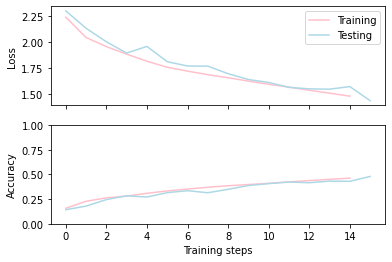

In [ ]:
visualization(train_losses2, train_accuracies2, test_losses2, test_accuracies2)

In [ ]:
layers_list = [tf.keras.layers.Conv2D(filters= 30, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=30, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=30, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(),
                tf.keras.layers.Conv2D(filters=60, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=60, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(),
                tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same', activation='relu'),
                tf.keras.layers.GlobalAvgPool2D(),
               ]


new_model2 = ConvModel(layers_list, optimizer)
train_losses3, train_accuracies3, test_losses3, test_accuracies3 = training_loop(new_model2, small_train_dataset, small_test_dataset, epochs)

Epoch 0: Accuracy 0.10080000013113022
Epoch 1: Accuracy 0.17589999735355377
Epoch 2: Accuracy 0.21610000729560852
Epoch 3: Accuracy 0.32510000467300415
Epoch 4: Accuracy 0.37139999866485596
Epoch 5: Accuracy 0.3840000033378601
Epoch 6: Accuracy 0.4027999937534332
Epoch 7: Accuracy 0.41110000014305115
Epoch 8: Accuracy 0.4212999939918518
Epoch 9: Accuracy 0.4560000002384186
Epoch 10: Accuracy 0.4740999937057495
Epoch 11: Accuracy 0.46540001034736633
Epoch 12: Accuracy 0.4602000117301941
Epoch 13: Accuracy 0.5224000215530396
Epoch 14: Accuracy 0.5177000164985657


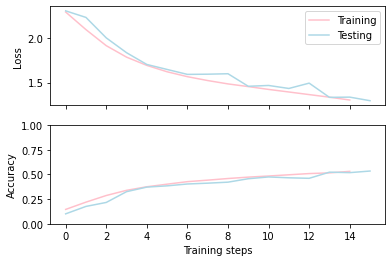

In [ ]:
visualization(train_losses3, train_accuracies3, test_losses3, test_accuracies3)

This version took even longer and got only marginally better results. 